In [1]:
import cftime
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from scipy.stats import genextreme as gev
import xclim as xc
from xclim import sdba
from xclim.sdba import nbutils

from unseen import fileio
from unseen import eva
from unseen import moments
from unseen import similarity
from unseen import bias_correction

/Users/irv033/opt/anaconda3/envs/unseen/lib/python3.13/site-packages/xclim/sdba/__init__.py:22: FutureWarning: The SDBA submodule is in the process of being split from `xclim` in order to facilitate development and effective maintenance of the SDBA utilities. The `xclim.sdba` functionality will change in the future. For more information, please visit https://xsdba.readthedocs.io/en/latest/.
  warnings.warn(


TODO:
- Select the correct time period for quantile bias correction
- Smooth the quantile adjustment factors with a function that can produce a value for the same number of quantiles as there are data values (i.e. so each data value gets a unique smoothed adjustment factor)

In [2]:
mildura_lat = -34.2
mildura_lon = 142.1

### Observations

In [3]:
#txx_obs_file = '/g/data/xv83/unseen-projects/outputs/txx/data/txx_AGCD-CSIRO_r05_1901-2024_annual-jul-to-jun_aus.nc'
txx_obs_file = '/Users/irv033/Desktop/txx_AGCD-CSIRO_r05_1901-2024_annual-jul-to-jun_aus.nc'

In [4]:
ds_obs = fileio.open_dataset(txx_obs_file)

In [5]:
da_obs = ds_obs['tasmax'].sel({'lat': mildura_lat, 'lon': mildura_lon}, method='nearest')

In [6]:
da_obs = da_obs.compute()

/Users/irv033/opt/anaconda3/envs/unseen/lib/python3.13/site-packages/xstatstests/scipy.py:246: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  outputs = func(args, **scipy_kwargs)
/Users/irv033/opt/anaconda3/envs/unseen/lib/python3.13/site-packages/xstatstests/scipy.py:246: UserWarning: p-value capped: true value larger than 0.25. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  outputs = func(args, **scipy_kwargs)


In [7]:
df_obs = da_obs.to_dataframe()

In [8]:
ranked_years = df_obs.sort_values(by='tasmax', ascending=False)
print(ranked_years.head(n=10))

                      lat    lon  event_time     tasmax
time                                                   
1990-06-30 00:00:00 -34.0  142.0  1990-01-03  48.070168
1939-06-30 00:00:00 -34.0  142.0  1939-01-10  47.354195
2001-06-30 00:00:00 -34.0  142.0  2001-01-14  47.192989
2020-06-30 00:00:00 -34.0  142.0  2019-12-20  46.924156
2019-06-30 00:00:00 -34.0  142.0  2019-01-04  46.915867
1979-06-30 00:00:00 -34.0  142.0  1979-01-14  46.859818
2017-06-30 00:00:00 -34.0  142.0  2017-02-10  46.850529
2009-06-30 00:00:00 -34.0  142.0  2009-02-07  46.835129
1932-06-30 00:00:00 -34.0  142.0  1932-01-27  46.403103
1982-06-30 00:00:00 -34.0  142.0  1982-01-24  46.376907


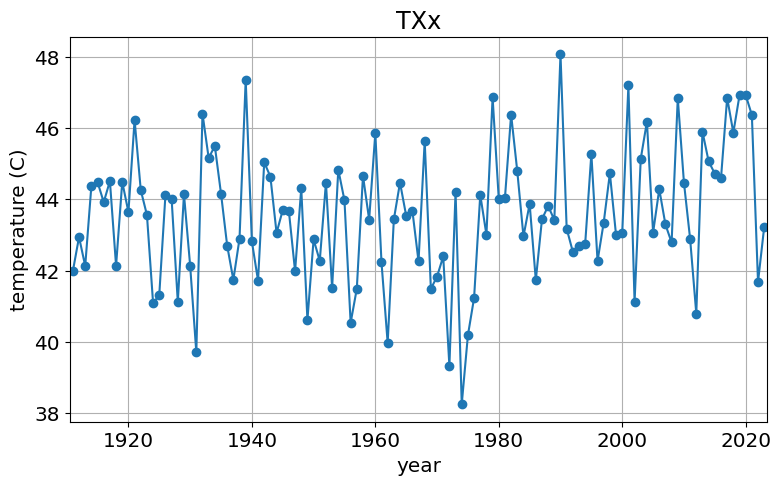

In [9]:
fig, ax = plt.subplots(figsize=[9, 5])
values = da_obs.values
years = da_obs['time'].dt.year.values
plt.plot(years, values, marker='o')
plt.xlim(years[0] - 0.5, years[-1] + 0.5)
plt.title('TXx')
plt.ylabel('temperature (C)')
plt.xlabel('year')
plt.grid()

In [10]:
gev_shape_obs, gev_loc_obs, gev_scale_obs = eva.fit_gev(da_obs.values)
print(f'Shape parameter: {gev_shape_obs:.2f}')
print(f'Location parameter: {gev_loc_obs:.2f}')
print(f'Scale parameter: {gev_scale_obs:.2f}')

Shape parameter: 0.30
Location parameter: 42.93
Scale parameter: 1.89


### Model data

In [11]:
#txx_model_file = '/g/data/xv83/unseen-projects/outputs/txx/data/txx_CanESM5-dcppA-hindcast_196101-201701_annual-jul-to-jun_aus.nc'
txx_model_file = '/Users/irv033/Desktop/txx_CanESM5-dcppA-hindcast_196101-201701_annual-jul-to-jun_aus.nc'

In [12]:
ds_model = fileio.open_dataset(txx_model_file)

In [13]:
da_model = ds_model['tasmax'].sel({'lat': -34.2, 'lon': 142.1}, method='nearest')

In [14]:
da_model = da_model.compute()

/Users/irv033/opt/anaconda3/envs/unseen/lib/python3.13/site-packages/xstatstests/scipy.py:246: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  outputs = func(args, **scipy_kwargs)
/Users/irv033/opt/anaconda3/envs/unseen/lib/python3.13/site-packages/xstatstests/scipy.py:246: UserWarning: p-value capped: true value larger than 0.25. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  outputs = func(args, **scipy_kwargs)


In [15]:
da_model_stacked = da_model.dropna('lead_time').stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [16]:
gev_shape_model, gev_loc_model, gev_scale_model = eva.fit_gev(da_model_stacked.values)
print(f'Shape parameter: {gev_shape_model:.2f}')
print(f'Location parameter: {gev_loc_model:.2f}')
print(f'Scale parameter: {gev_scale_model:.2f}')

Shape parameter: 0.25
Location parameter: 45.05
Scale parameter: 2.27


### Mean correction

#### Additive

In [17]:
bias_mean_add = bias_correction.get_bias(
    da_model,
    da_obs,
    'additive',
    time_rounding='A',
    time_period=['1972-01-01', '2018-12-31']
)

In [18]:
da_model_bc_mean_add = bias_correction.remove_bias(da_model, bias_mean_add, 'additive')

In [19]:
da_model_bc_mean_add = da_model_bc_mean_add.compute()

In [20]:
da_model_bc_mean_add_stacked = da_model_bc_mean_add.dropna('lead_time').stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [21]:
gev_shape_model_bc_mean_add, gev_loc_model_bc_mean_add, gev_scale_model_bc_mean_add = eva.fit_gev(da_model_bc_mean_add_stacked.values)
print(f'Shape parameter: {gev_shape_model_bc_mean_add:.2f}')
print(f'Location parameter: {gev_loc_model_bc_mean_add:.2f}')
print(f'Scale parameter: {gev_scale_model_bc_mean_add:.2f}')

Shape parameter: 0.25
Location parameter: 42.97
Scale parameter: 2.27


#### Multiplicative

In [22]:
bias_mean_mulc = bias_correction.get_bias(
    da_model,
    da_obs,
    'multiplicative',
    time_rounding='A',
    time_period=['1972-01-01', '2018-12-31']
)

In [23]:
da_model_bc_mean_mulc = bias_correction.remove_bias(da_model, bias_mean_mulc, 'additive')
da_model_bc_mean_mulc = da_model_bc_mean_mulc.compute()

In [24]:
da_model_bc_mean_mulc_stacked = da_model_bc_mean_mulc.dropna('lead_time').stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [25]:
gev_shape_model_bc_mean_mulc, gev_loc_model_bc_mean_mulc, gev_scale_model_bc_mean_mulc = eva.fit_gev(da_model_bc_mean_mulc_stacked.values)
print(f'Shape parameter: {gev_shape_model_bc_mean_mulc:.2f}')
print(f'Location parameter: {gev_loc_model_bc_mean_mulc:.2f}')
print(f'Scale parameter: {gev_scale_model_bc_mean_mulc:.2f}')

Shape parameter: 0.25
Location parameter: 44.00
Scale parameter: 2.27


### Quantile correction

In [117]:
nquantiles = 10
quantile_array = xc.sdba.utils.equally_spaced_nodes(nquantiles)

In [118]:
quantile_array

array([0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95])

In [119]:
da_model_q = nbutils.quantile(da_model_stacked, quantile_array, ['sample'])

In [120]:
da_model_q.values

array([42.192577, 43.621677, 44.476234, 45.078236, 45.63127 , 46.17791 ,
       46.746624, 47.3693  , 48.15235 , 49.442856], dtype=float32)

In [121]:
da_obs_q = nbutils.quantile(da_obs, quantile_array, ['time'])

In [122]:
da_obs_q.values

array([40.579037, 41.70889 , 42.267696, 42.904892, 43.374233, 43.8482  ,
       44.247734, 44.635292, 45.52076 , 46.854244], dtype=float32)

In [123]:
bias_quantile_add = da_model_q.values - da_obs_q.values

In [124]:
bias_quantile_add

array([1.6135406, 1.9127884, 2.208538 , 2.1733437, 2.257038 , 2.329708 ,
       2.49889  , 2.7340088, 2.6315918, 2.5886116], dtype=float32)

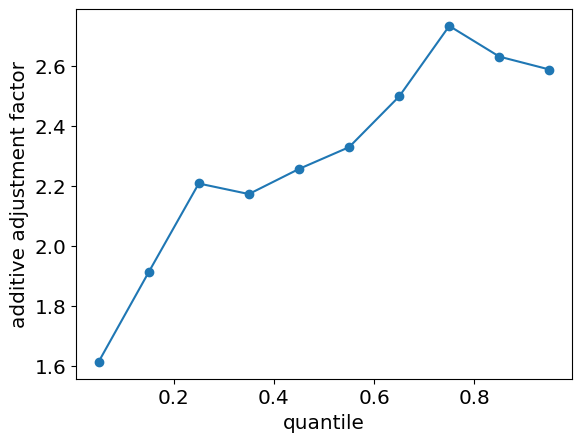

In [125]:
plt.plot(quantile_array, bias_quantile_add, marker='o')
plt.xlabel('quantile')
plt.ylabel('additive adjustment factor')
plt.show()

In [126]:
bias_quantile_mulc = da_model_q.values / da_obs_q.values

In [127]:
bias_quantile_mulc

array([1.0397629, 1.0458604, 1.0522512, 1.0506549, 1.0520364, 1.0531312,
       1.0564749, 1.0612521, 1.0578108, 1.0552481], dtype=float32)

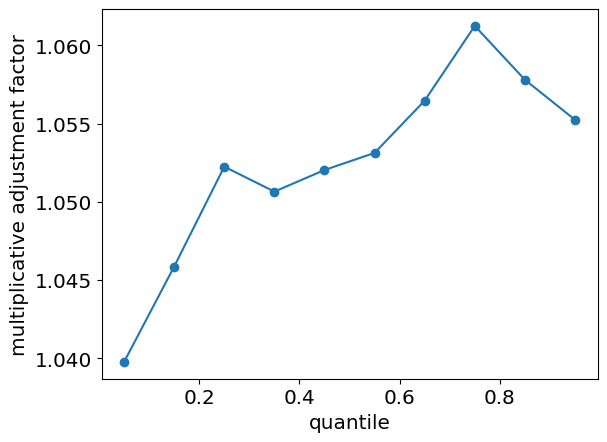

In [128]:
plt.plot(quantile_array, bias_quantile_mulc, marker='o')
plt.xlabel('quantile')
plt.ylabel('multiplicative adjustment factor')
plt.show()

In [129]:
def get_adjustment_factor(value, quantiles, adjustment_factors):
    """Find the adjustment factor corresponding to the closest quantile."""

    assert quantiles.shape == adjustment_factors.shape
    
    difference_array = np.absolute(quantiles - value)
    index = difference_array.argmin()
    adjustment_factor = adjustment_factors[index]

    return adjustment_factor

vget_adjustment_factor = np.vectorize(get_adjustment_factor, excluded=['quantiles', 'adjustment_factors'])

#### Additive

In [130]:
af_add = vget_adjustment_factor(
    da_model_stacked.values,
    quantiles=da_model_q.values,
    adjustment_factors=bias_quantile_add,
)

In [131]:
da_model_bc_quantile_add = da_model_stacked - af_add

In [132]:
gev_shape_model_bc_quantile_add, gev_loc_model_bc_quantile_add, gev_scale_model_bc_quantile_add = eva.fit_gev(da_model_bc_quantile_add.values)
print(f'Shape parameter: {gev_shape_model_bc_quantile_add:.2f}')
print(f'Location parameter: {gev_loc_model_bc_quantile_add:.2f}')
print(f'Scale parameter: {gev_scale_model_bc_quantile_add:.2f}')

Shape parameter: 0.22
Location parameter: 42.84
Scale parameter: 1.96


#### Multiplicative

In [133]:
af_mulc = vget_adjustment_factor(
    da_model_stacked.values,
    quantiles=da_model_q.values,
    adjustment_factors=bias_quantile_mulc,
)

In [134]:
da_model_bc_quantile_mulc = da_model_stacked / af_mulc

In [135]:
gev_shape_model_bc_quantile_mulc, gev_loc_model_bc_quantile_mulc, gev_scale_model_bc_quantile_mulc = eva.fit_gev(da_model_bc_quantile_mulc.values)
print(f'Shape parameter: {gev_shape_model_bc_quantile_mulc:.2f}')
print(f'Location parameter: {gev_loc_model_bc_quantile_mulc:.2f}')
print(f'Scale parameter: {gev_scale_model_bc_quantile_mulc:.2f}')

Shape parameter: 0.23
Location parameter: 42.85
Scale parameter: 1.94


## Comparison

In [136]:
def fidelity_tests(da_target):
    """Perform fidelity tests."""
    
    similarity_scores = similarity.similarity_tests(da_target, da_obs)
    print('KS score:', similarity_scores['ks_statistic'].values)
    print('KS p-value:', similarity_scores['ks_pval'].values)
    print('AD score:', similarity_scores['ad_statistic'].values)
    print('AD p-value:', similarity_scores['ad_pval'].values)

    moments.create_plot(
        da_model,
        da_obs,
        da_bc_fcst=da_target,
    )

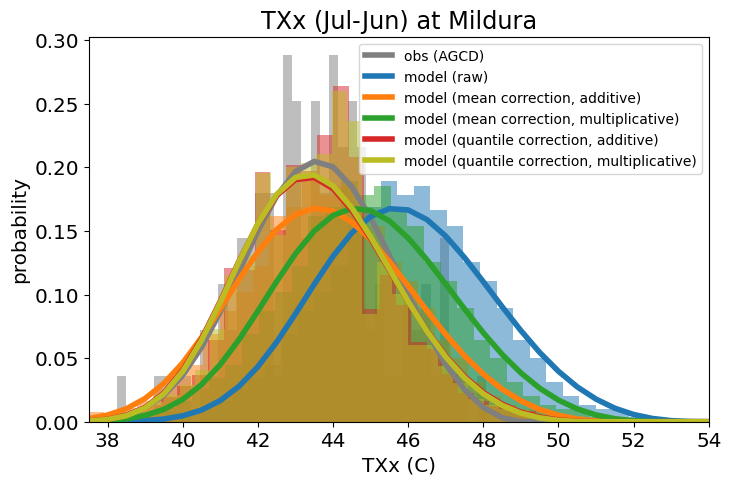

In [137]:
fig, ax = plt.subplots(figsize=[8, 5])
gev_xvals = np.arange(30, 65, 0.5)

da_obs.plot.hist(bins=40, density=True, color='tab:gray', alpha=0.5)
gev_pdf_obs = gev.pdf(gev_xvals, gev_shape_obs, gev_loc_obs, gev_scale_obs)
plt.plot(gev_xvals, gev_pdf_obs, color='tab:gray', linewidth=4.0, label='obs (AGCD)')

da_model_stacked.plot.hist(bins=40, density=True, color='tab:blue', alpha=0.5)
gev_pdf_model = gev.pdf(gev_xvals, gev_shape_model, gev_loc_model, gev_scale_model)
plt.plot(gev_xvals, gev_pdf_model, color='tab:blue', linewidth=4.0, label='model (raw)')

da_model_bc_mean_add_stacked.plot.hist(bins=40, density=True, color='tab:orange', alpha=0.5)
gev_pdf_model_bc_mean_add = gev.pdf(
    gev_xvals,
    gev_shape_model_bc_mean_add,
    gev_loc_model_bc_mean_add,
    gev_scale_model_bc_mean_add
)
plt.plot(
    gev_xvals,
    gev_pdf_model_bc_mean_add,
    color='tab:orange',
    linewidth=4.0,
    label='model (mean correction, additive)'
)

da_model_bc_mean_mulc_stacked.plot.hist(bins=40, density=True, color='tab:green', alpha=0.5)
gev_pdf_model_bc_mean_mulc = gev.pdf(
    gev_xvals,
    gev_shape_model_bc_mean_mulc,
    gev_loc_model_bc_mean_mulc,
    gev_scale_model_bc_mean_mulc
)
plt.plot(
    gev_xvals,
    gev_pdf_model_bc_mean_mulc,
    color='tab:green',
    linewidth=4.0,
    label='model (mean correction, multiplicative)'
)

da_model_bc_quantile_add.plot.hist(bins=40, density=True, color='tab:red', alpha=0.5)
gev_pdf_model_bc_quantile_add = gev.pdf(
    gev_xvals,
    gev_shape_model_bc_quantile_add,
    gev_loc_model_bc_quantile_add,
    gev_scale_model_bc_quantile_add
)
plt.plot(
    gev_xvals,
    gev_pdf_model_bc_quantile_add,
    color='tab:red',
    linewidth=4.0,
    label='model (quantile correction, additive)'
)

da_model_bc_quantile_mulc.plot.hist(bins=40, density=True, color='tab:olive', alpha=0.5)
gev_pdf_model_bc_quantile_mulc = gev.pdf(
    gev_xvals,
    gev_shape_model_bc_quantile_mulc,
    gev_loc_model_bc_quantile_mulc,
    gev_scale_model_bc_quantile_mulc
)
plt.plot(
    gev_xvals,
    gev_pdf_model_bc_quantile_mulc,
    color='tab:olive',
    linewidth=4.0,
    label='model (quantile correction, multiplicative)'
)

plt.xlabel('TXx (C)')
plt.ylabel('probability')
plt.title(f'TXx (Jul-Jun) at Mildura')
plt.xlim(37.5, 54)
plt.legend(fontsize='medium')
plt.savefig('txx_mildura_gevs.png', bbox_inches='tight', facecolor='white')
plt.show()

### Raw data

In [64]:
similarity_ds = similarity.similarity_tests(da_model, da_obs)
print('KS score:', similarity_ds['ks_statistic'].values)
print('KS p-value:', similarity_ds['ks_pval'].values)
print('AD score:', similarity_ds['ad_statistic'].values)
print('AD p-value:', similarity_ds['ad_pval'].values)

KS score: 0.4875908
KS p-value: 4.6272845e-25
AD score: 81.58321
AD p-value: 0.001


### Additive - mean correction

KS score: 0.116772756
KS p-value: 0.08692746
AD score: 0.79016525
AD p-value: 0.15519488


INFO:root:mean: Obs = 43.56737518310547, Model 95% CI =45.45615463256836 to 46.29805850982666
INFO:root:standard deviation: Obs = 1.8655565977096558, Model 95% CI =1.9007485538721085 to 2.556455820798874
INFO:root:skew: Obs = -0.050572533160448074, Model 95% CI =-0.7251034826040268 to 0.37963547259569164
INFO:root:kurtosis: Obs = -0.05454087257385254, Model 95% CI =-0.6168384611606598 to 1.8517182946205133
INFO:root:GEV shape: Obs = <xarray.DataArray 'tasmax' ()> Size: 8B
array(0.30247233)
Coordinates:
    lat      float64 8B -34.0
    lon      float64 8B 142.0
    dparams  <U5 20B 'c'
Attributes:
    long_name:    Genextreme parameters
    description:  Parameters of the genextreme distribution
    method:       MLE
    estimator:    LMM
    scipy_dist:   genextreme
    units:        , Model 95% CI =0.16609779838082944 to 0.441402935297297
INFO:root:GEV location: Obs = <xarray.DataArray 'tasmax' ()> Size: 8B
array(42.92739216)
Coordinates:
    lat      float64 8B -34.0
    lon      fl

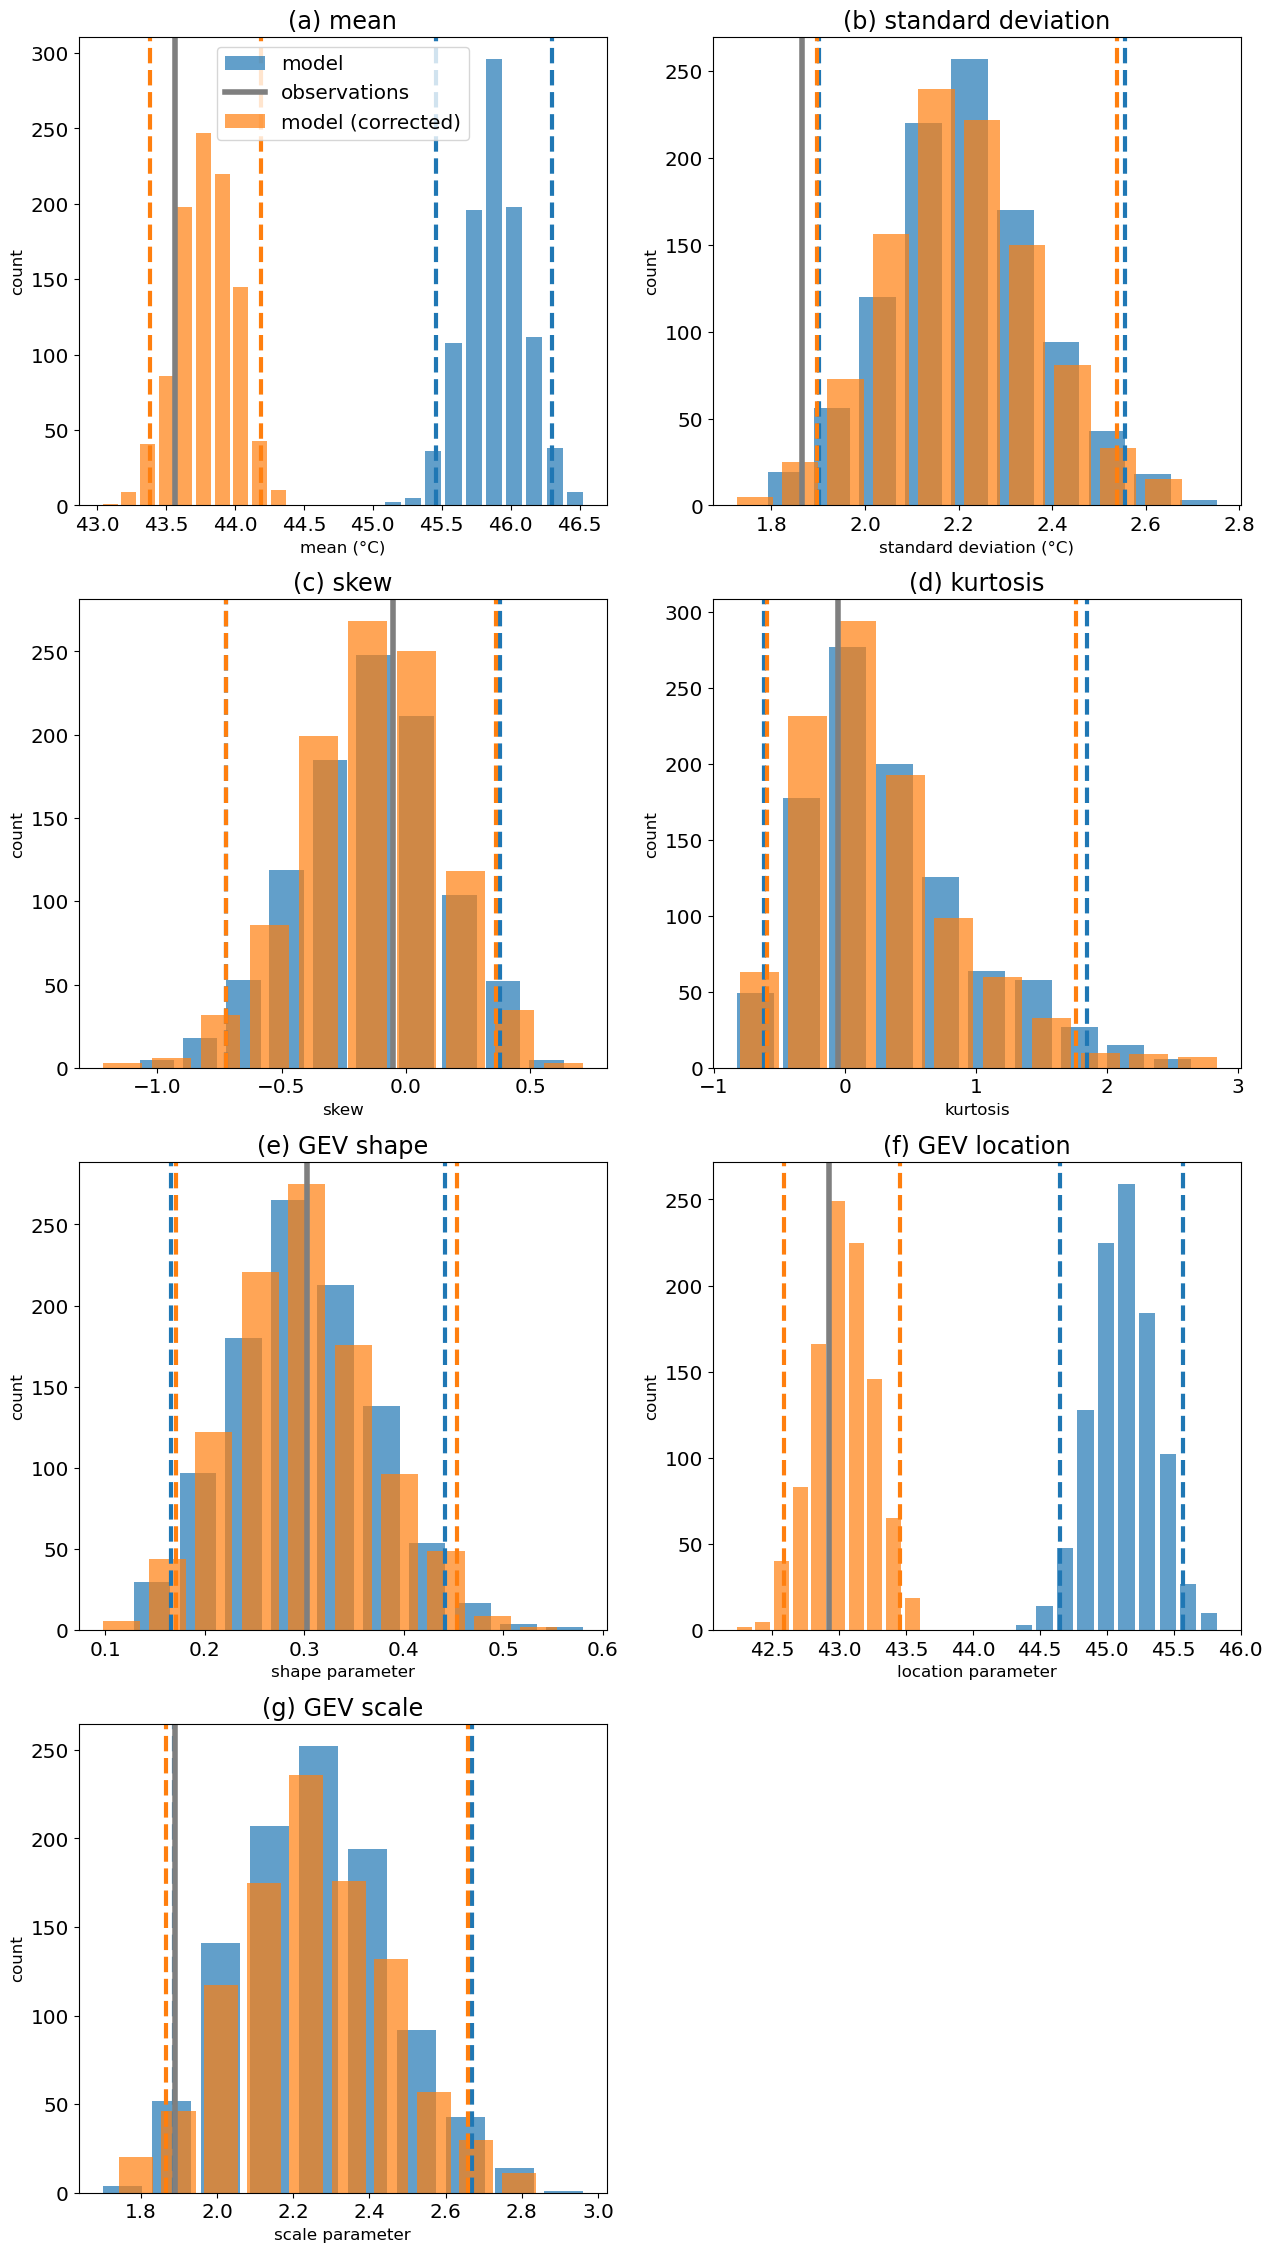

In [71]:
fidelity_tests(da_model_bc_mean_add)

### Multiplicative - mean correction

KS score: 0.30221066
KS p-value: 1.4292246e-09
AD score: 25.51588
AD p-value: 0.001


INFO:root:mean: Obs = 43.56737518310547, Model 95% CI =45.43410272598267 to 46.31375141143799
INFO:root:standard deviation: Obs = 1.8655565977096558, Model 95% CI =1.88968326151371 to 2.567891556024551
INFO:root:skew: Obs = -0.050572533160448074, Model 95% CI =-0.7354753017425537 to 0.3728111080825328
INFO:root:kurtosis: Obs = -0.05454087257385254, Model 95% CI =-0.5956488668918609 to 1.7641858696937553
INFO:root:GEV shape: Obs = <xarray.DataArray 'tasmax' ()> Size: 8B
array(0.30247233)
Coordinates:
    lat      float64 8B -34.0
    lon      float64 8B 142.0
    dparams  <U5 20B 'c'
Attributes:
    long_name:    Genextreme parameters
    description:  Parameters of the genextreme distribution
    method:       MLE
    estimator:    LMM
    scipy_dist:   genextreme
    units:        , Model 95% CI =0.17615245231240895 to 0.4509873513104043
INFO:root:GEV location: Obs = <xarray.DataArray 'tasmax' ()> Size: 8B
array(42.92739216)
Coordinates:
    lat      float64 8B -34.0
    lon      floa

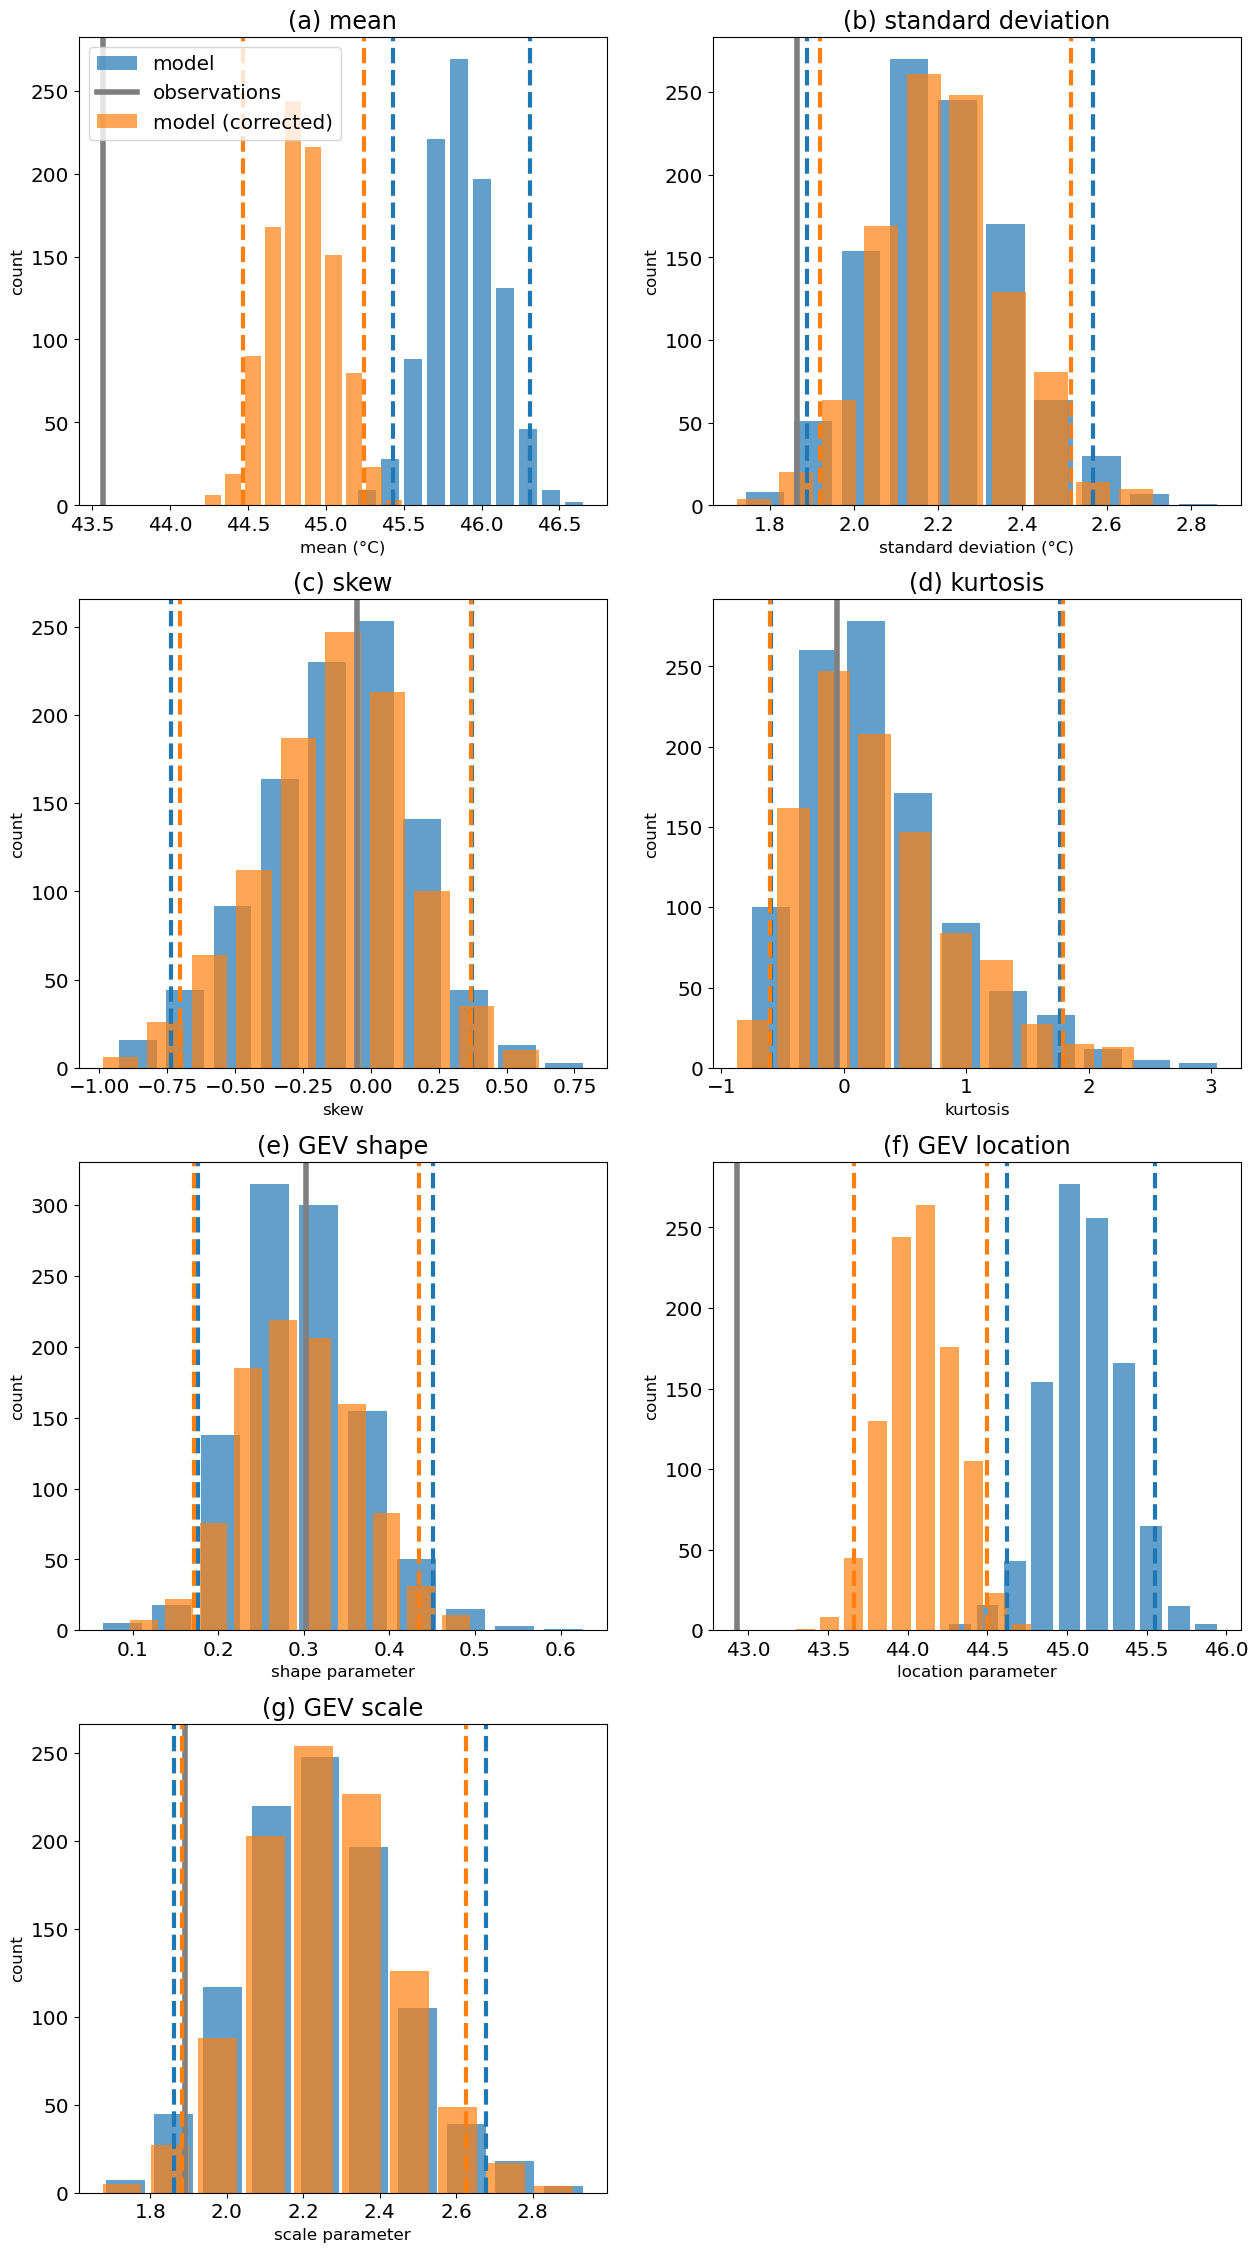

In [72]:
fidelity_tests(da_model_bc_mean_mulc)

### Additive - quantile correction

KS score: 0.038151424
KS p-value: 0.99483645
AD score: -1.1385604
AD p-value: 0.25


INFO:root:mean: Obs = 43.56737518310547, Model 95% CI =45.45339593887329 to 46.306377696990964
INFO:root:standard deviation: Obs = 1.8655565977096558, Model 95% CI =1.899870938062668 to 2.5541563510894774
INFO:root:skew: Obs = -0.050572533160448074, Model 95% CI =-0.7299410566687584 to 0.4176804289221763
INFO:root:kurtosis: Obs = -0.05454087257385254, Model 95% CI =-0.5708201825618744 to 1.8723959803581236
INFO:root:GEV shape: Obs = <xarray.DataArray 'tasmax' ()> Size: 8B
array(0.30247233)
Coordinates:
    lat      float64 8B -34.0
    lon      float64 8B 142.0
    dparams  <U5 20B 'c'
Attributes:
    long_name:    Genextreme parameters
    description:  Parameters of the genextreme distribution
    method:       MLE
    estimator:    LMM
    scipy_dist:   genextreme
    units:        , Model 95% CI =0.16290768014381174 to 0.4411163615580925
INFO:root:GEV location: Obs = <xarray.DataArray 'tasmax' ()> Size: 8B
array(42.92739216)
Coordinates:
    lat      float64 8B -34.0
    lon      f

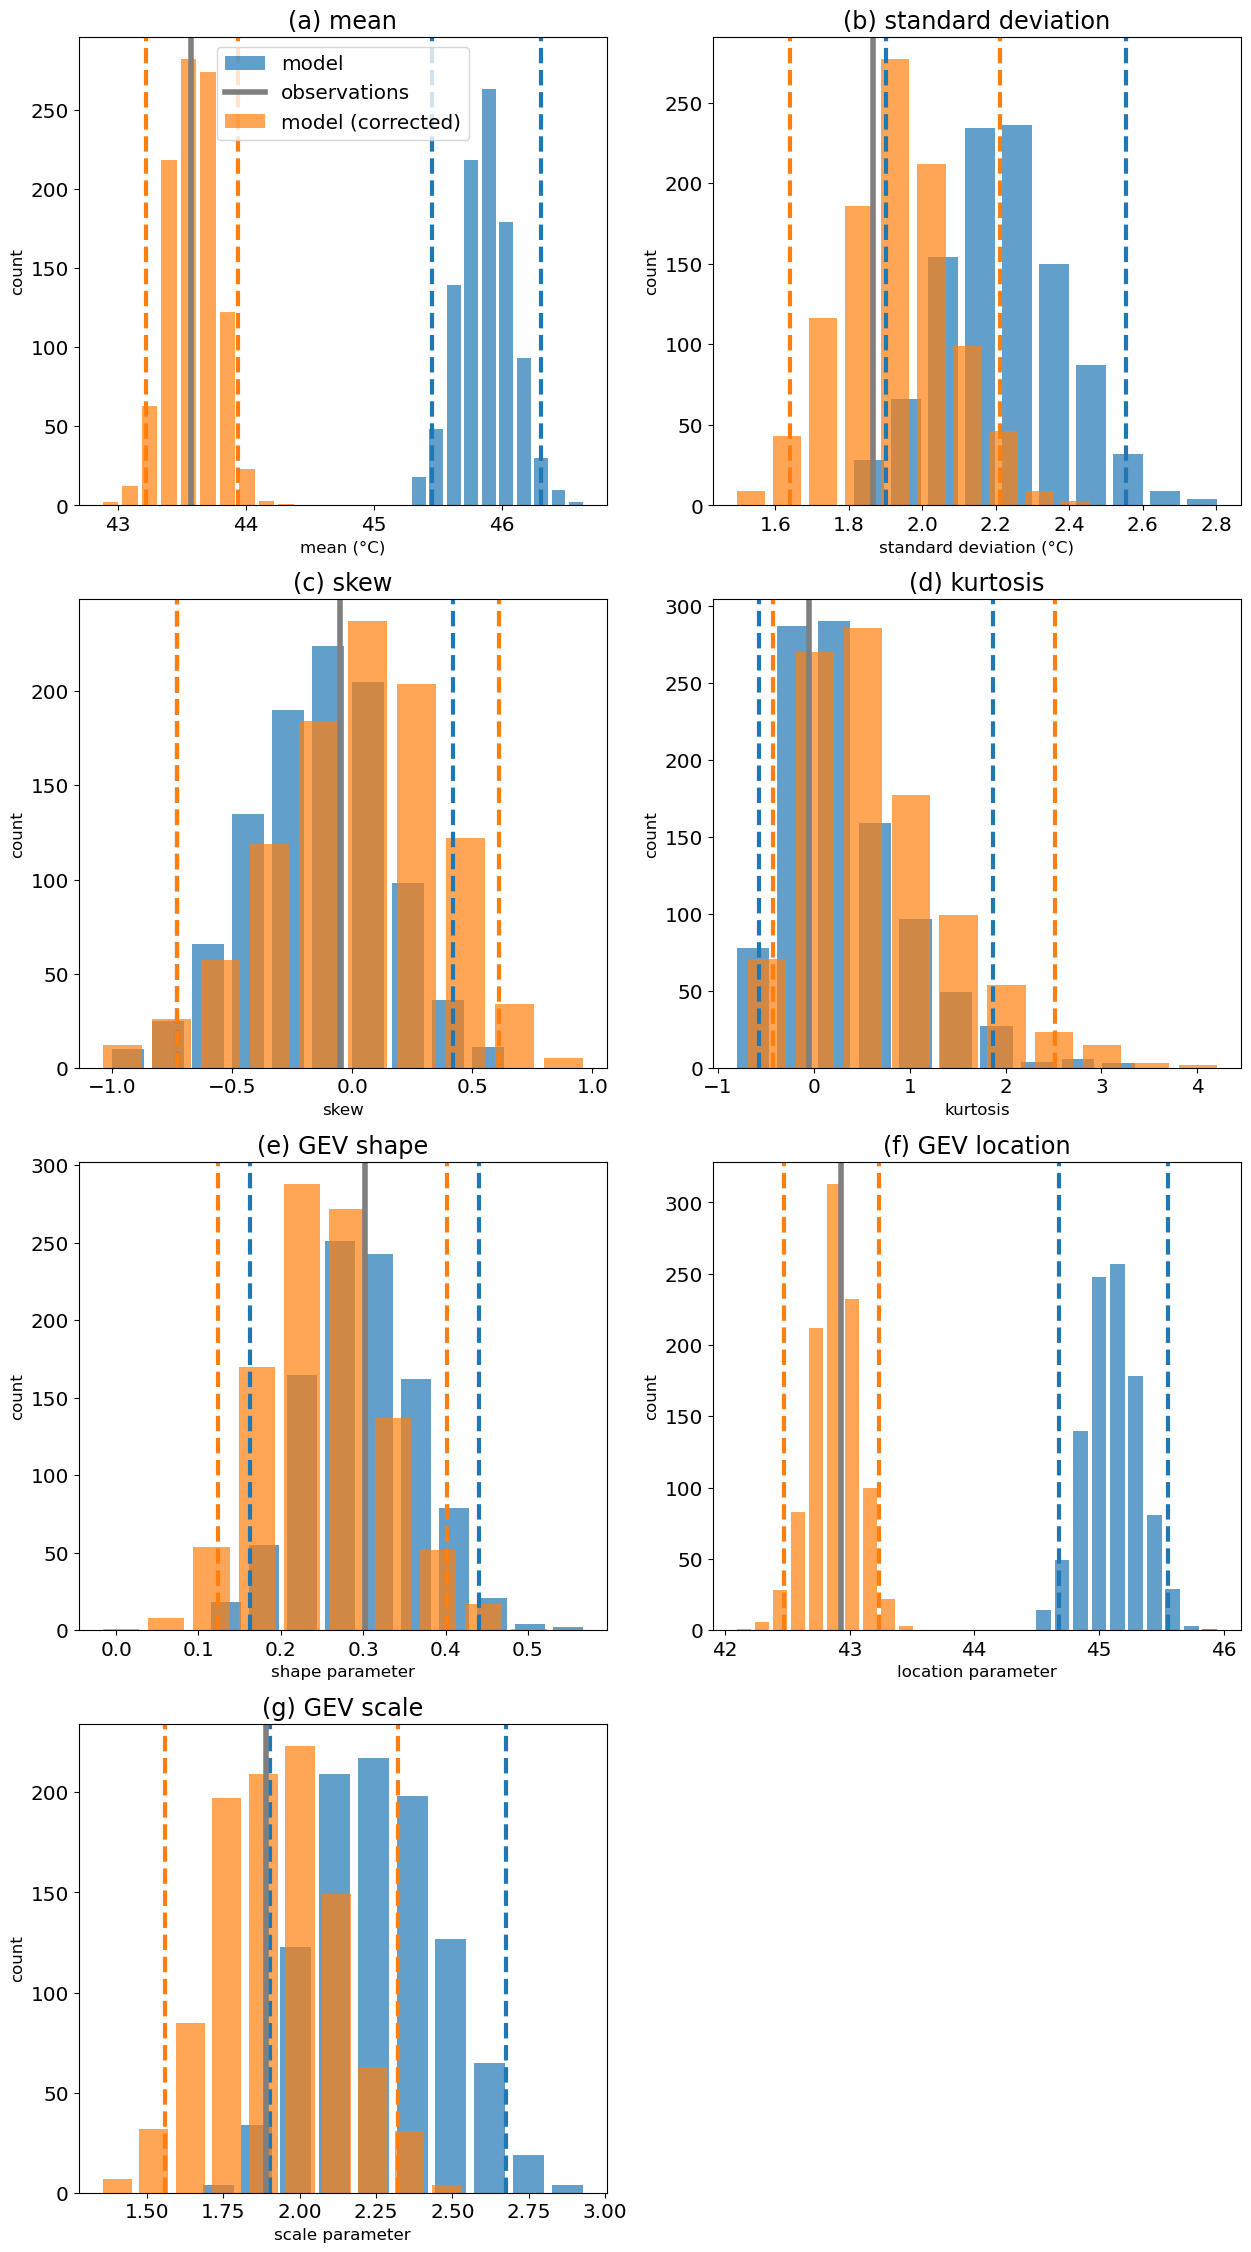

In [157]:
fidelity_tests(da_model_bc_quantile_add.unstack())

### Multiplicative - quantile correction

KS score: 0.036884367
KS p-value: 0.99668926
AD score: -1.1427748
AD p-value: 0.25


INFO:root:mean: Obs = 43.56737518310547, Model 95% CI =45.46322889328003 to 46.30312337875366
INFO:root:standard deviation: Obs = 1.8655565977096558, Model 95% CI =1.903800442814827 to 2.556653332710266
INFO:root:skew: Obs = -0.050572533160448074, Model 95% CI =-0.7850526884198189 to 0.3786416098475455
INFO:root:kurtosis: Obs = -0.05454087257385254, Model 95% CI =-0.5637640178203582 to 1.8779749870300286
INFO:root:GEV shape: Obs = <xarray.DataArray 'tasmax' ()> Size: 8B
array(0.30247233)
Coordinates:
    lat      float64 8B -34.0
    lon      float64 8B 142.0
    dparams  <U5 20B 'c'
Attributes:
    long_name:    Genextreme parameters
    description:  Parameters of the genextreme distribution
    method:       MLE
    estimator:    LMM
    scipy_dist:   genextreme
    units:        , Model 95% CI =0.17174844565982522 to 0.4427712869046107
INFO:root:GEV location: Obs = <xarray.DataArray 'tasmax' ()> Size: 8B
array(42.92739216)
Coordinates:
    lat      float64 8B -34.0
    lon      flo

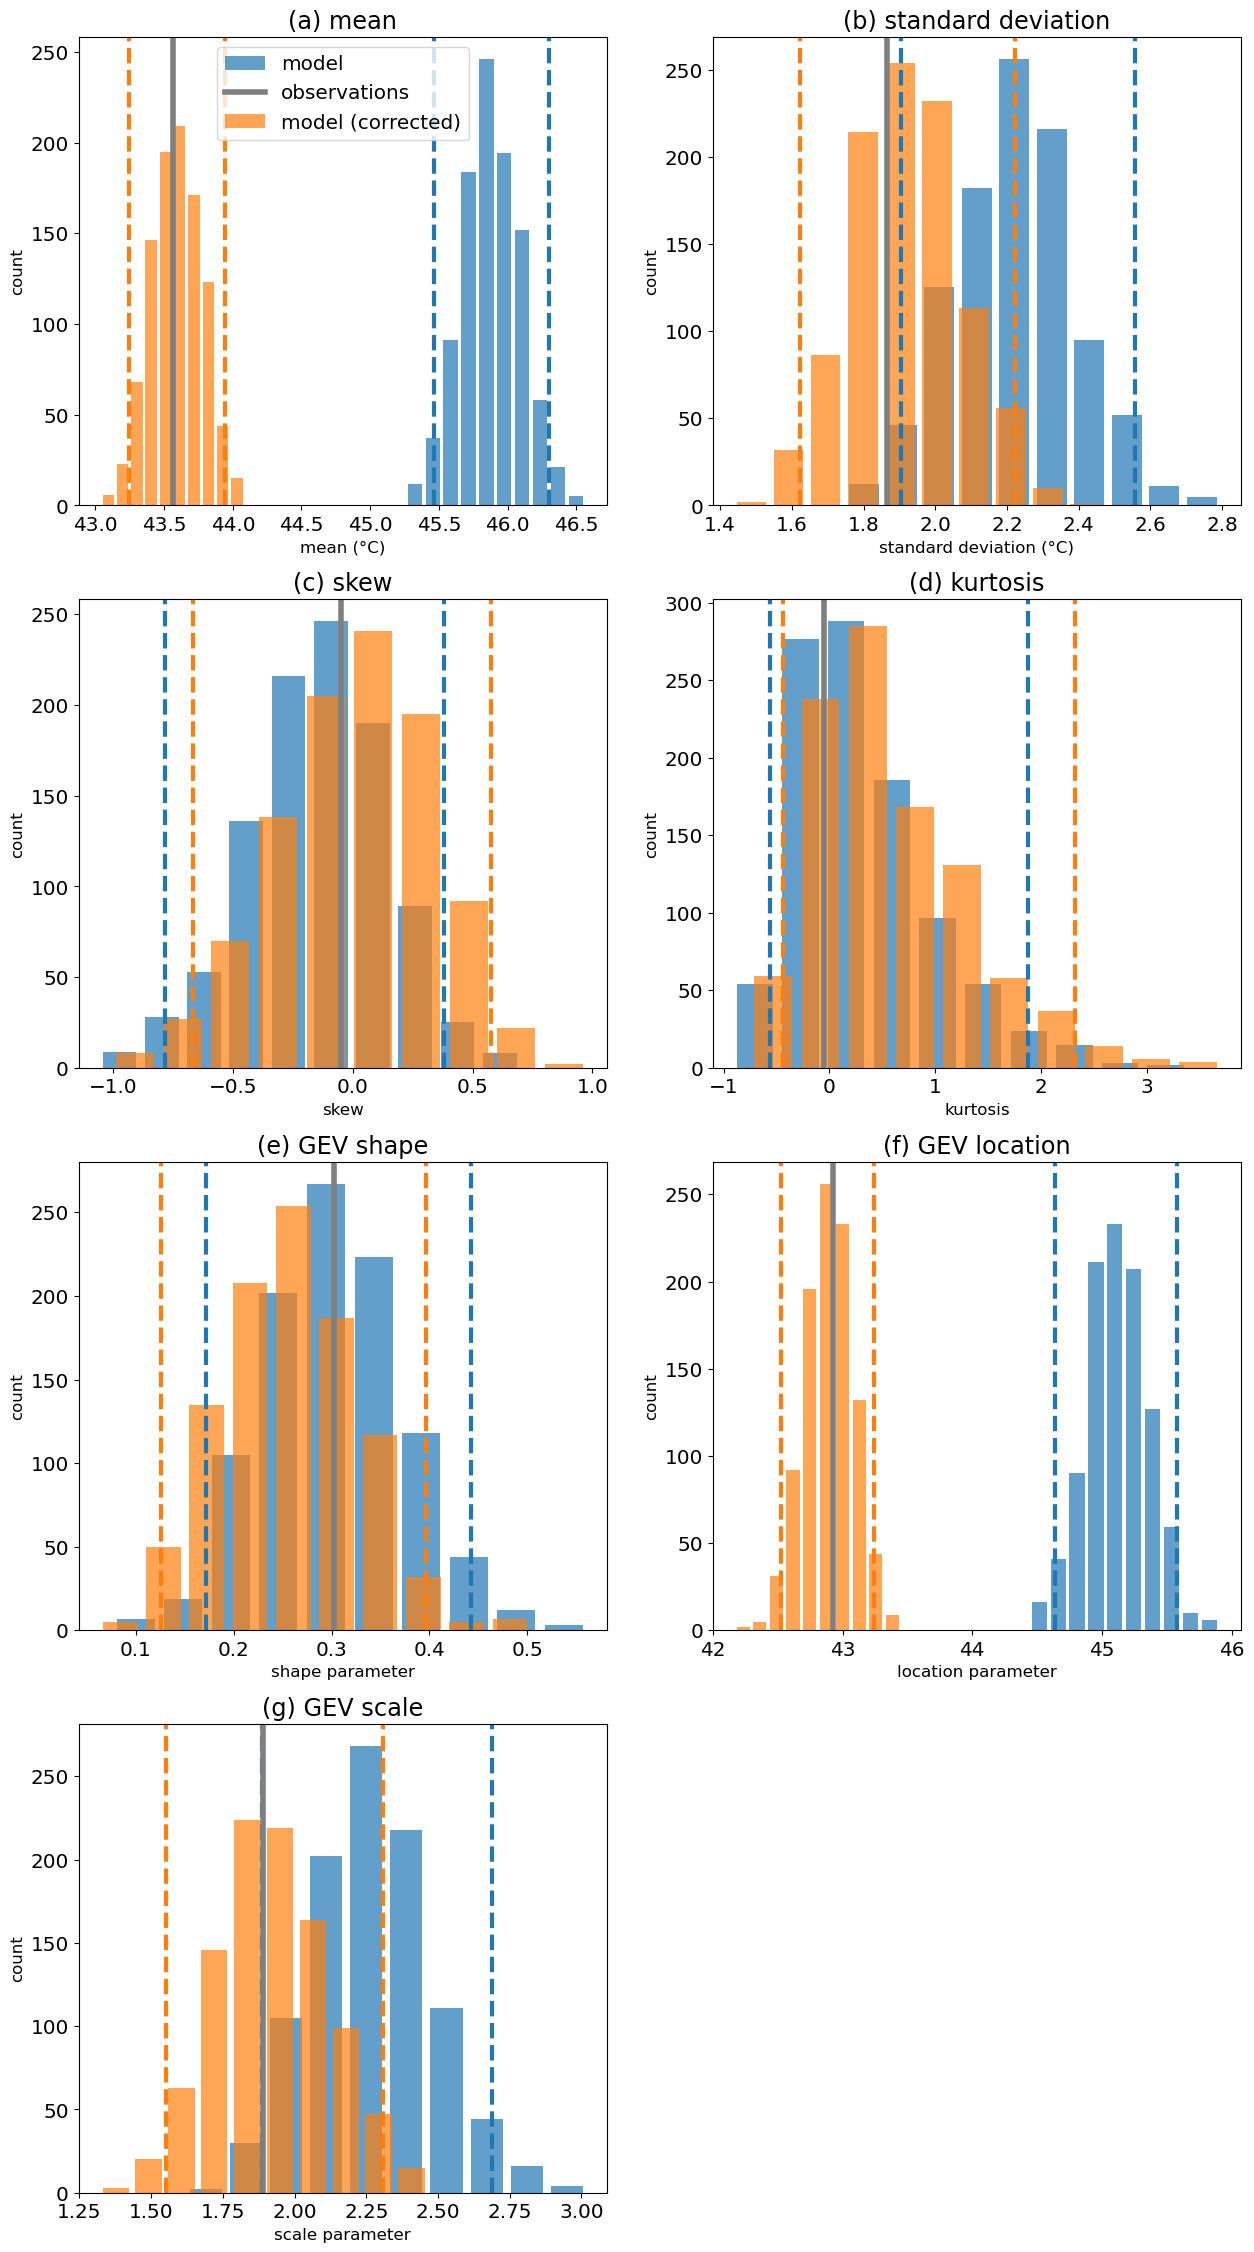

In [158]:
fidelity_tests(da_model_bc_quantile_mulc.unstack())